**Projet de programmation : Mini-échecs (5x6) et algorithmes Minimax et Alpha-Beta**

*Vincent De Chaisemartin et Naël Farhan, Projet Python 1A ENSAE*


  **Introduction**

   L’immense succès du Jeu de la Dame, série produite par Netflix, a grandement contribué au récent renouveau des échecs, jeu déjà très populaire auparavant, mais qui a vu son nombre de pratiquants très fortement croître ces derniers mois.

Ce renouveau a lieu dans un contexte de remise en cause de certains aspects de la pratique traditionnelle des échecs. Ainsi, les parties officielles sont tout d’abord souvent décriées parce que trop longues pour générer l’intérêt d’un large public, que ce soit en tant que joueur ou en tant que spectateur. L’accélération des cadences, avec le développement du blitz (des parties durant moins de 10 minutes), permet de remédier à cela.

Cependant, un autre aspect des échecs peut freiner leur attractivité auprès du grand public. En effet, l’étude de ce jeu depuis des siècles a engendré l’écriture de nombreux traités de théorie qu’il s’agit de maîtriser si l’on souhaite jouer convenablement, ce qui peut rebuter les néophytes souhaitant pouvoir rapidement prendre du plaisir en jouant.

C’est pourquoi nous croyons que l’avenir est aux variantes comme Minichess : n’ayant pas connu de tels développements théoriques, elles permettent aux joueurs de confronter leurs capacités de calcul et de compréhension pure des positions plutôt que l’étendue de leurs connaissances en matière d’ouverture et de finales, phases du jeu particulièrement décortiquées par la théorie du jeu d’échecs. Par ailleurs, elle peut permettre aux débutants souhaitant apprendre les échecs classiques de se concentrer sur ces aspects du jeu qui font la différence avant de commencer à étudier la théorie.

Minitchess, la variante que nous allons vous présenter, se joue sur un plateau de taille 5x6, contrairement aux échecs classiques qui se jouent sur un plateau 8x8. Chaque joueur dispose d’une tour, d’un cavalier, d’un fou, d’une reine et d’un roi dans l’ordre de gauche à droite sur la première rangée, et de pions sur la deuxième rangée. Les blancs commencent, et un joueur l’emporte quand il prend le roi adverse (en sachant qu’il est possible de placer le roi sur une case où il peut être pris). Si 40 coups sont joués de chaque côté sans qu’émerge un vainqueur, la partie se termine en match nul. Les pièces se déplacent comme dans la version originale du jeu, à ceci près que le fou peut, en plus de ses déplacements habituels, se déplacer d’une case au nord, à l’est, à l’ouest ou au sud, à condition qu’aucune pièce adverse ne s’y trouve. Contrairement aux échecs classiques, le roque et le double mouvement des pions sont interdits. Enfin, quand un pion atteint l’autre côté du plateau, il est automatiquement promu en dame.

Dans ce notebook, nous coderons tout d'abord différents objets sous forme de classe afin de définir les règles ainsi que plusieurs fonctions permettant de mettre à jour le plateau. Nous présenterons ensuite 2 algorithmes d'intelligence artificielle qui peuvent jouer aux mini-échecs, en se basant sur les algorithmes mini-max, puis nous donnerons la possibilité au lecteur de jouer contre l'un de ces algorithmes. Nous ferons enfin jouer les différents algorithmes entre eux, afin de tenter de déterminer si les améliorations se ressentent dans les résultats.


Nous n'aurons besoin que des module 'time' et 'random' dans ce projet, le reste étant fait à la main car il n'y a pas de module d'échecs en 5x6 sur Python. Nous créons également 2 dictionnaires qui créent des correspondances entre la notation classique (anglaise) des échecs ('p' : pion noir, 'R' : tour blanche par exemple) avec des noms de pièces, ainsi qu'avec des symboles de pièces d'échecs.

In [1]:
import time
import random

pieces_aff = {'r':'♜', 'n':'♞', 'b':'♝', 'q':'♛', 'k':'♚', 'p':'♟','R':'♖', 'N':'♘', 'B':'♗', 'Q':'♕', 'K':'♔', 'P':'♙', '.':'·'}
pieces_noms = {
        'p': 'pawn', 'n': 'knight', 'b': 'bishop', 'r': 'rook', 'q': 'queen',
        'P': 'pawn', 'N': 'knight', 'B': 'bishop', 'R': 'rook', 'Q': 'queen',
        'k': 'king', 'K': 'king', '.': 'empty'    }


**I - Construction du plateau, implémentation des règles et fonctions auxiliaires**

Nous codons tout d'abord 3 classes d'objets : le plateau dans une certaine position, un coup avec la pièce associée et les cases d'arrivée et de départ et une case avec la pièce qui y est présente s'il y en a une. Pour les classes 'coup' et 'case', nous ajoutons également quelques courtes fonctions qui suivront dans la suite.

In [2]:
class Position:
    
    def __init__(self, plateau=None, coup=None, coups_joues=None):
        if plateau is None: # début de partie si pas de position donnée en argument
            self.plateau = []
            self.plateau.append(['k', 'q', 'b', 'n', 'r'])
            self.plateau.append(['p', 'p', 'p', 'p', 'p'])
            self.plateau.append(['.', '.', '.', '.', '.'])
            self.plateau.append(['.', '.', '.', '.', '.'])
            self.plateau.append(['P', 'P', 'P', 'P', 'P'])
            self.plateau.append(['R', 'N', 'B', 'Q', 'K'])
            self.coup = 'W' # définit à qui le tour, à ne pas confondre avec un coup, initialisé au joueur blanc
            self.coups_joues = 1
        else:
            self.plateau = plateau
        self.coup = 'W' if coup is None else coup
        self.coups_joues = 1 if coups_joues is None else coups_joues # servira quand il faudra déterminer s'il y a match nul, à plus de 40 coups joués

        maj_pieces(self) # la fonction maj_pieces est définie plus tard 
        self.valeur_pieces = {
          'k': 200, 'q': 9, 'r': 5, 'b': 3, 'n': 3, 'p': 1,
          'K': 200, 'Q': 9, 'R': 5, 'B': 3, 'N': 3, 'P': 1 } # on donne des valeurs aux pièces, ce qui servira lors des définitions des fonctions d'évaluation
        
        self.coups = genere_coups(self) # genere_coups est aussi définie plus tard
        self.coups_strings = [m.en_string() for m in self.coups] # c'est la fonction en_string de la classe coup

        self.ancienne_position = [] # servira à l'annulation de coups lorsque les algortihmes minmax parcourront les coups possibles
        # les 3 outils suivant serviront pour l'utilisation des algorithmes minmax
        self.time_spent = 0
        self.time_counter = 0
        self.time_limit = 0 

class Case:
    def __init__(self, ligne, col, val):
        assert ligne <= 5 and ligne >= 0
        assert col <= 4 and col >= 0
        self.ligne = ligne
        self.col = col
        self.val = val
        self.name = pieces_noms.get(val)

    def __eq__(self, other):# permet de comparer deux cases en appelant '=='
        if self.ligne == other.ligne and self.col == other.col:
            if self.val == other.val:
                return True
        return False

    def en_string(self):
        return '{} (ligne: {}, col: {})'.format(self.val, self.ligne, self.col)

    def rank(self): # est utile pour afficher le plateau avec la notation classique 'lettre-chiffre' pour une case
        return '{}{}'.format(chr(ord('a') + self.col), 6 - self.ligne)

    def print_case(self):
        print(self.en_string())

class Coup:
    def __init__(self, depuis_case, vers_case):
        self.vers_case = vers_case
        self.depuis_case = depuis_case

    def en_string(self):
        return '{}-{}'.format(self.depuis_case.rank(), self.vers_case.rank())

def print_coup(coup, verbose=False):
    if verbose:
        print('{} -> {}'.format(
            coup.depuis_case.en_string(), coup.vers_case.en_string()
        ))
    else:
        print(coup.en_string())

In [ ]:
## A quoi ça ressemble pour l'instant ?
Position().plateau

[['k', 'q', 'b', 'n', 'r'],
 ['p', 'p', 'p', 'p', 'p'],
 ['.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.'],
 ['P', 'P', 'P', 'P', 'P'],
 ['R', 'N', 'B', 'Q', 'K']]

In [ ]:
Position().coups_strings

['a2-a3', 'b2-b3', 'c2-c3', 'd2-d3', 'e2-e3', 'b1-a3', 'b1-c3']

In [ ]:
Position().coups[0].depuis_case.print_case()
## c'est le pion blanc en case a2 (la correspondance viendra après)

P (ligne: 4, col: 0)


Voici maintenant plusieurs fonctions qui s'appliquent à un plateau : ce sont ces fonctions qui implémentent les règles

In [3]:
def maj_pieces(position):
    #met à jour les pièces et leur position sur le plateau
    position.pieces_noires = []
    position.pieces_blanches = []
    for ligne in range(6):
        for col in range(5):
            piece = position.plateau[ligne][col]
            if piece.isupper():
                position.pieces_blanches.append(piece)
            elif piece.islower():
                position.pieces_noires.append(piece)

def print_position(position): 
    print(position.coup, position.coups_joues) # montre à qui est le tour, et combien de coups ont été joué
    r_num = 6
    for ligne in range(6):
        for col in range(5):
            print(pieces_aff.get(position.plateau[ligne][col]), end=' ')
        print('{} '.format(r_num))
        r_num -= 1
    for i in range(0, 5):
        print(chr(ord('a') + i), end=' ')
    print('')

def recupere_pieces(position): #récupère les pièces (de type 'case') du plateau
    pieces = []
    for ligne in range(6):
        for col in range(5):
            val = position.plateau[ligne][col]
            if str.isupper(val) and position.coup == 'W':
                pieces.append(Case(ligne, col, val))
            elif str.islower(val) and position.coup == 'B':
                pieces.append(Case(ligne, col, val))
    return pieces

def scan(position, piece, dl, dc, stop_short, capture):
    ligne = piece.ligne
    col = piece.col
    coups = []
    while True: 
        ligne = ligne + dl
        col = col + dc
        if ligne < 0 or ligne >= 6:
            break
        if col < 0 or col >= 5:
            break
        val = position.plateau[ligne][col]
        if val != '.':  # une pièce est présente
            if str.isupper(val) and position.coup == 'W':
                break
            if str.islower(val) and position.coup == 'B':
                break
            if str(capture) == 'false':
                break
            stop_short = True
        elif str(capture) == 'only':
            break
        coup_ = Coup(piece, Case(ligne, col, val))
        coups.append(coup_)
        if stop_short is True:
            break
    return coups

def sym_scan(position, piece, dl, dc, stop_short, capture): # les dl et dc sont utilisés astucieusement pour trouver les cases atteignables par une pièce
    coups = []
    for i in range(0, 4):
        coups += scan(position, piece, dl, dc, stop_short, capture)
        dl, dc = dc, dl
        dl = dl * -1
    return coups

def genere_coups_pour_piece(position, piece):
    coups = []
    if piece.name == 'pawn':
        dl = 1
        if position.coup == 'W':
            dl = -1
        coups += scan(position, piece, dl, -1, True, 'only')
        coups += scan(position, piece, dl, 1, True, 'only')
        coups += scan(position, piece, dl, 0, True, 'false')
    elif piece.name == 'knight':
        coups += sym_scan(position, piece, -1, 2, True, 'true')
        coups += sym_scan(position, piece, 1, 2, True, 'true')
    elif piece.name == 'rook' or piece.name == 'bishop':
        stop_short = True if piece.name == 'bishop' else False
        capture = 'true' if piece.name == 'rook' else 'false'
        coups += sym_scan(position, piece, 1, 0, stop_short, capture)
        if piece.name == 'bishop':
            stop_short = False
            capture = 'true'
            coups += sym_scan(position, piece, 1, 1, stop_short, capture)
    elif piece.name == 'king' or piece.name == 'queen':  
        stop_short = True if piece.name == 'king' else False
        coups += sym_scan(position, piece, 0, 1, stop_short, 'true')
        coups += sym_scan(position, piece, 1, 1, stop_short, 'true')
    return coups

def genere_coups(position):
    coups = []
    pieces = recupere_pieces(position)
    for piece in pieces:
        coups += genere_coups_pour_piece(position, piece)
    return coups

Réalisons un test unitaire sur la fonction genere_coups_pour_piece : dans la situation initiale, pour le pion blanc en a2, le seul coup possible est a3 ; pour le cavalier en b1, les coups possibles sont a3 ou c3. Maintenant, supposons que les blancs jouent a2-a3 : la dame noire en b6 ne peut aller nulle part, tout comme le roi noir en a6.

In [ ]:
import unittest

a = Position()

b = Position()
coup_b = Coup(Case(4,0,'P'),Case(3,0,'.'))
joue_coup(b,coup_b)  # fonction définie plus bas, qui ne fait pas appel à genere_coups_pour_piece

class Testgenere(unittest.TestCase):
  # quand c'est aux blancs de jouer
  def test_pion_a2(self):
    c = Case(4,0,'P')
    g = genere_coups_pour_piece(a,c)
    self.assertEqual(len(g),1)
    self.assertEqual(g[0].en_string(),'a2-a3')

  def test_cav_b1(self):
    c = Case(5,1,'n')
    g = genere_coups_pour_piece(a,c)
    self.assertEqual(len(g),2)
    self.assertEqual(g[0].en_string(),'b1-a3')
    self.assertEqual(g[1].en_string(),'b1-c3')
  
  # quand c'est aux noirs de jouer
  def test_roi_a6(self):
    c = Case(0,0,'k')
    g = genere_coups_pour_piece(b,c)
    self.assertEqual(g,[])

  def test_dame_b6(self):
    c = Case(0,1,'q')
    g = genere_coups_pour_piece(b,c)
    self.assertEqual(g,[])

unittest.main(argv=[''], verbosity=2, exit=False)


test_cav_b1 (__main__.Testgenere) ... ok
test_dame_b6 (__main__.Testgenere) ... ok
test_pion_a2 (__main__.Testgenere) ... ok
test_roi_a6 (__main__.Testgenere) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


In [ ]:
# Exemple de la situation de départ
a=Position()
print_position(a)

W 1
♚ ♛ ♝ ♞ ♜ 6 
♟ ♟ ♟ ♟ ♟ 5 
· · · · · 4 
· · · · · 3 
♙ ♙ ♙ ♙ ♙ 2 
♖ ♘ ♗ ♕ ♔ 1 
a b c d e 


Nous nous sommes aperçus que sur ce notebook, un léger décalage se crée alors qu'il y a un alignement sur spyder ou pyzo ; c'est un petit problème que nous ne savons pas résoudre, mais qui gêne peu lorsque l'on joue.

A présent viennent des fonctions qui peuvent jouer ou annuler un coup, ainsi qu'une fonction qui servira à l'utilisateur qui voudra jouer contre un des algorithmes : le joueur n'aura qu'à écire un coup sous la forme 'c2-c3' par exemple, et la fonction fera les modifications nécessaires.

In [4]:
def joue_coup(position, coup):
    depuis_case = coup.depuis_case
    vers_case = coup.vers_case
    piece = position.plateau[depuis_case.ligne][depuis_case.col]
    dest = position.plateau[vers_case.ligne][vers_case.col]
    position.ancienne_position.append((coup, piece, dest)) # sauvegarde le coup joué s'il est nécessaire de l'annuler plus tard
    position.plateau[depuis_case.ligne][depuis_case.col] = '.'
    position.plateau[vers_case.ligne][vers_case.col] = piece
    # mise à jour des pièces si l'une a été prise
    if dest != '.' and dest.islower():  # pièce noire
        position.pieces_noires.remove(dest)
    elif dest != '.' and dest.isupper():  # pièce blanche
        position.pieces_blanches.remove(dest)
    # promotion des pions en dame
    if piece == 'p' and vers_case.ligne == 5:
        position.plateau[vers_case.ligne][vers_case.col] = 'q'
        position.pieces_noires.remove('p')
        position.pieces_noires.append('q')
    elif piece == 'P' and vers_case.ligne == 0:
        position.plateau[vers_case.ligne][vers_case.col] = 'Q'
        position.pieces_blanches.remove('P')
        position.pieces_blanches.append('Q')
    position.coup = 'B' if position.coup == 'W' else 'W'
    position.coups_joues += 1 if position.coup == 'W' else 0

def annule_coup(position):
    if len(position.ancienne_position) > 0:
        info = position.ancienne_position.pop()
        coup = info[0]
        piece = info[1]
        dest = info[2]
        depuis_case = coup.depuis_case
        vers_case = coup.vers_case
        # annule le coup
        position.plateau[depuis_case.ligne][depuis_case.col] = piece
        position.plateau[vers_case.ligne][vers_case.col] = dest
        # remet en jeu la pièce qui avait été prise
        if dest != '.' and dest.islower():
            position.pieces_noires.append(dest)
        elif dest != '.' and dest.isupper():
            position.pieces_blanches.append(dest)
        # cas d'annulation d'un coup de promotion
        if piece == 'p' and vers_case.ligne == 5:
            position.pieces_noires.append('p')
            position.pieces_noires.remove('q')
        elif piece == 'P' and vers_case.ligne == 0:
            position.pieces_blanches.append('P')
            position.pieces_blanches.remove('Q')
        position.coups_joues -= 1 if position.coup == 'W' else 0
        position.coup = 'B' if position.coup == 'W' else 'W'

def envoyer_coup(position, coup_j):
    def get_case_from_rank(rank):
        assert len(rank) == 2
        col = ord(rank[0]) - ord('a')
        ligne = 6 - int(rank[1])
        val = position.plateau[ligne][col]
        return Case(ligne, col, val)
    from_rank = coup_j.split('-')[0]
    to_rank = coup_j.split('-')[1]
    depuis_case = get_case_from_rank(from_rank)
    vers_case = get_case_from_rank(to_rank)
    coup_ = Coup(depuis_case, vers_case)
    m_strings = [m.en_string() for m in genere_coups(position)]
    if coup_.en_string() in m_strings:
        return joue_coup(position, coup_)
    else:
        raise Exception('coup invalide')

Nous définissons enfin une fonction qui détermine dans une position si la partie est toujours en cours, s'il y a match nul ou s'il y a un vainqueur.

In [5]:
def vainqueur(position):
    roi_noir = False
    roi_blanc = False
    for ligne in range(6):
        for col in range(5):
            if position.plateau[ligne][col] == 'k':
                roi_noir = True
            elif position.plateau[ligne][col] == 'K':
                roi_blanc = True
    if roi_noir and roi_blanc and position.coups_joues <= 40:
        return '?'  # la partie est en cours
    elif roi_noir and roi_blanc and position.coups_joues > 40:
        return '='  # match nul
    elif not roi_noir and roi_blanc:
        return 'W'  # victoire des blancs
    elif roi_noir and not roi_blanc:
        return 'B'  # victoire des noirs
    elif not roi_noir and not roi_blanc:
        return '='


**II - Implémentation des algorithmes de mini-max suivant différentes fonction d'évaluation**

Nous allons désormais implémenter deux algorithmes se basant sur les algorithmes minimax. Il nous faut pour cela tout d'abord définir des fonctions d'évaluation, qui donnent pour le joueur qui a la main un score par rapport à sa position. Plus le score est élevé, plus il est à l'avantage dudit joueur.

La première fonction d'évaluation est relativement simple. En se basant sur les valeurs des différentes pièces définies dans la classe 'position', elle compare la somme des valeurs des pièces d'un joueur à celle de l'autre joueur. 

La deuxième ajoute une autre composante qui est celui du développement des pièces sur le plateau. Le score de développement est d'autant plus élevé que les pièces sont au centre du plateau, et que les pions sont loins de leur ligne. On garde quand même un poids important sur la "différence de pièces" entre les 2 joueurs pour cette fonction ; notons par ailleurs qu'en terme de complexité, elle ne rajoute pas beaucoup de calculs.

In [6]:
def evaluate_1(position):
    player = 1 if position.coup == 'W' else -1
    score_blanc = sum([position.valeur_pieces[piece] for piece in position.pieces_blanches])
    score_noir = sum([position.valeur_pieces[piece] for piece in position.pieces_noires])
    return (score_blanc - score_noir) * player

def evaluate_2(position):
    player = 1 if position.coup == 'W' else -1
    score_blanc = sum([position.valeur_pieces[piece] for piece in position.pieces_blanches])
    score_noir = sum([position.valeur_pieces[piece] for piece in position.pieces_noires])
    score_pieces = ((score_blanc - score_noir) * player) * 100
    dev_blanc = dev_noir = 0  # score sur l'avancement des pièces
    for ligne in range(6):
        for col in range(5):
            piece = position.plateau[ligne][col]
            if piece != '.':
                if ligne > 2 and ligne < 5 and col > 0 and col < 4:
                    if piece.isupper():
                        dev_blanc += 1
                    else:
                        dev_noir += 1
            if piece == 'P':
                dev_blanc += 6 - ligne
            elif piece == 'p':
                dev_noir += ligne
            elif piece in ['N', 'B', 'R'] and ligne != 5:
                dev_blanc += 1
            elif piece in ['n', 'b', 'r'] and ligne != 0:
                dev_noir += 1
    score_dev = (dev_blanc - dev_noir) * player
    return score_pieces + score_dev

On définit aussi une fonction qui va renvoyer le meilleur des coups possibles pour un joueur, ce qui servira plus tard ; par "meilleur" on entend dans ce cas celui qui amène la meilleure évaluation après avoir joué ce coup (potentiellement on peut perdre une dame juste après).

In [11]:
def coups_ord(position,evaluate):
    coups = genere_coups(position)
    coups_evalues = []
    for coup in coups:
        joue_coup(position, coup)
        score = evaluate(position)
        annule_coup(position)
        coups_evalues.append((score, coup))
    ord = sorted(coups_evalues, key=lambda x: x[0])
    return [coup[1] for coup in ord]

Voici maintenant les algos minimax et alpha beta, qui dépendent des fonction d'évaluation et sont toutes 2 récursives. 
Le premier algorithme est un algorithme classique dans de nombreux jeux qui se jouent à 2 ; Deep Blue, qui a battu le champion du monde d'échecs Kasparov à la fin des années 90, était un programme d'échecs basé sur le principe minimax.

Cet algorithme se déroule sur un arbre qui représente tous les coups possibles jusqu'à une certaine profondeur, donnée en argument. Il se base sur le fait qu'un joueur cherche à maximiser sa position en anticipant que le joueur d'en face fasse de même. Plaçons nous dans le cas où un score élevé (et positif) est "bon" pour le joueur blanc, et un score bas (et négatif) est "bon" pour le joueur noir. Expliquons via un exemple comment cela fonctionne : on supposera ici que seuls deux coups sont possibles à chaque fois. Evidemment aux échecs il y en a bien plus, et le nombre de fils d'un noeud n'est pas fixe puisqu'au fil du jeu des pièces peuvent avoir accès à plus ou moins de cases.


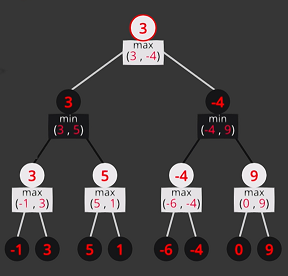

On commence en bas à gauche de l'arbre. Dans les deux positions, c'est aux noirs de jouer ; les deux positions sont évaluées à -1 et 3. Sur le fils de ces deux noeuds, c'est aux blancs de jouer : pour maximiser sa position, il joue donc le coup qui mène au score 3 ; le poids de ce noeud correspond donc au maximum des poids, qui est 3. Pour le frère de ce noeud, on a comme score 5. Ainsi, le noeud noir à gauche sur la deuxième ligne correspond au tour des noirs. Ses deux choix mène à une évaluation de 3 ou de 5 ; comme le joueur noir veut minimiser ce score, il décide de jouer le coup menant à 3. En itérant ce procédé en fonction de la profondeur demandée, on arrive à un arbre qui permet pour le joueur blanc d'atteindre dans 4 coups un score de 3. 

Il est alors naturel d'utiliser la récursivité pour implémenter l'algorithme.
Nous ajoutons également une composante temporelle dans la durée de parcours de l'algorithme. Lorsque nous ferons jouer des algorithmes ensemble, nous pourrons ainsi faire en sorte que chacun aie le même temps de réflexion pour jouer un coup afin qu'ils puissent s'affronter "équitablement".

Notons par ailleurs que dans notre code, nous avons décidé que la fonction d'évaluation dépende de qui doit jouer dans une position : le joueur cherche toujours à avoir un score élevé dans les positifs. Ceci explique l'appel à "-minimax" lors de l'appel récursif.

Enfin, si plusieurs coups ont la même évaluation, l'algorithme en joue un au hasard.

In [7]:
def minimax(position, prof, evaluate): 
    position.time_counter += 1
    if position.time_counter > 1000:
        position.time_counter = 0
        position.time_spent = int(time.time() * 1000) 
    if position.time_spent > position.time_limit:
        return 0
    if prof <= 0 or vainqueur(position) != '?':
        return evaluate(position)
    score = float('-inf')
    coups = coups_ord(position,evaluate)
    for coup in coups:
        joue_coup(position, coup)
        score = max(score, -minimax(position, prof - 1, evaluate))
        annule_coup(position)
    return score

def joue_minimax(position, prof, duration, evaluate):
    position.time_spent = int(time.time() * 1000)
    position.time_limit = int(position.time_spent + duration)
    position.time_counter = 0

    coups = coups_ord(position, evaluate)
    best_coup = ''
    for d in range(1, prof + 1):
        score = float('-inf')
        candidate = []
        for coup in coups:
            joue_coup(position, coup)
            temp = -minimax(position, d - 1, evaluate)
            annule_coup(position)
            if temp > score:
                candidate = [coup]
                score = temp
            elif temp == score :
              candidate.append(coup) 
        if position.time_spent > position.time_limit:
            break
        best_coup = random.choice(candidate)
    if best_coup == '':
        best_coup = coups[0]
        print('Plus de temps, joue le meilleur coup à 1 coup')
    return best_coup

Une amélioration classique de cet algorithme est l'élagage alpha-beta. Il permet d'avoir à ne pas aller explorer des branches de l'arbre des possibles puisqu'elle ne serve à rien dans le parcours. Reprenons l'exemple précédent :

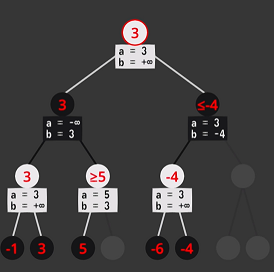

On parcourt les coups de la dernière ligne. Après avoir évalué les premiers coups à -1 et 3, on arrive au noeud de valeur 5. On sait donc que l'algorithme minimax pondérera le père de ce noeud à une valeur supérieure à 5. Or, sur le noeud fils, c'est aux noirs de jouer, et il sait qu'il peut obtenir un score 3 (qui est inférieur à 5) en jouant à gauche dans l'arbre. Ainsi, évaluer ce noeud voisin du 5 est inutile puisque l'on arrivera jamais à cette situation. Dans cet exemple, un autre élagage conséquent se fait puisqu'on évite l'évaluation de 3 noeuds. Néanmoins, il est possible qu'il y aie peu d'élagages possibles dans l'arbre, mais l'algorithme reste plus efficace que le minimax et, pour une durée de parcours donnée, pourra aller plus en profondeur dans l'arbre.

On va utiliser là encore de la récursivité. Le contrôle des branches à ne pas parcourir se fait via l'utilisation de variables alpha et beta, qui sont représentées sur l'exemple par 'a' et 'b'.

In [8]:
def alpha_beta(position, prof, alpha, beta, evaluate):
    position.time_counter += 1
    if position.time_counter > 1000:
        position.time_counter = 0
        position.time_spent = int(time.time() * 1000)
    if position.time_spent > position.time_limit:
        return 0
    if prof <= 0 or vainqueur(position) != '?':
        return evaluate(position)
    score = float('-inf')
    for coup in coups_ord(position, evaluate):
        joue_coup(position, coup)
        score = max(score, -alpha_beta(position, prof - 1, -beta, -alpha, evaluate))
        annule_coup(position)
        alpha = max(alpha, score)
        if alpha >= beta:
            break
    return score

def joue_alpha_beta(position, prof, duration, evaluate):
    position.time_spent = int(time.time() * 1000)
    position.time_limit = int(position.time_spent + duration)
    position.time_counter = 0
    best_coup = ''
    coups = coups_ord(position, evaluate)
    for d in range(1, prof + 1):
        alpha = float('-inf')
        beta = float('inf')
        candidate = []
        for coup in coups:
            joue_coup(position, coup)
            temp = -alpha_beta(position, d - 1, -beta, -alpha, evaluate)
            annule_coup(position)
            if temp > alpha:
                candidate = [coup]
                alpha = temp
            elif temp == alpha:
                candidate.append(coup)
        if position.time_spent > position.time_limit:
            break
        best_coup = random.choice(candidate)
    if best_coup == '':
        best_coup = coups[0]
        print('Plus de temps, joue le meilleur coup à 1 coup')
    return best_coup

**III - Jouer contre l'algortihme de son choix**

Après ces longs préparatifs, nous pouvons enfin coder les fonctions permettant à n'importe quel utilisateur de jouer. Nous lui donnons la possibilité de jouer avec les blancs ou avec les noirs, et contre l'algorithme de son choix. 
L'utilisateur peut d'ailleurs reprendre une partie en cours s'il donne en argument un plateau déjà avancé. Il peut choisir contre quel algorithme jouer, et avec quelle fonction d'évaluation ce dernier sera implémenté. Si aucun algorithme n'est donné en argument, il jouera contre l'algorithme naïf qui joue le meilleur coup possible à un coup près (qui peut par exemple manger un pion même si cela implique de perdre sa dame au coup suivant).

En ce qui concerne le jeu des algorithmes, on fixe un certain temps de parcours, égal pour les 2 algorithmes ; en théorie alpha_beta est meilleur donc on lui propose d'aller plus en profondeur dans l'arbre des possibles. Néanmoins, si l'on arrive à battre ces algorithmes, on pourra augmenter ces valeurs (profondeur et 'duration') pour augmenter la difficulté.

In [9]:
def blanc_contre_algo(position,evaluate,algo=None):
    print("Vous jouez les blancs")
    while vainqueur(position) == '?':
        print('________________________')
        print_position(position)
        if position.coup == 'W':
            coup = input("ton coup: ")
            try:
                if coup == 'coups': # permet d'obtenir tous les coups possibles
                    [print(m.en_string()) for m in genere_coups(position)]
                else:
                    envoyer_coup(position, coup)
            except:
                print('coup invalide, réessaie')
                continue
        else:
            if algo == 'alpha_beta':
                coup = joue_alpha_beta(position, 8, 3000, evaluate)
            elif algo == 'minimax':
                coup = joue_minimax(position, 4, 3000, evaluate)
            else:  #ne joue que le meilleur coup à un coup près
                coup = coups_ord(position, evaluate)[0]
            print('algo joue {}'.format(coup.en_string()))
            joue_coup(position, coup)
    print('game over')
    Loser = position.coup  
    Vainqueur = 'B' if Loser == 'W' else 'W'
    print('{} loses, {} wins'.format(Loser, vainqueur))
    print_position(position)

def noir_contre_algo(position, evaluate, algo=None):
    print("Vous jouez les noirs")
    while vainqueur(position) == '?':
        print('________________________')
        print_position(position)
        if position.coup == 'B':
            coup = input("ton coup: ")
            try:
                if coup == 'coups':
                    [print(m.en_string()) for m in genere_coups(position)]
                else:
                    envoyer_coup(position, coup)
            except:
                print('coup invalide, réessaie')
                continue
        else:
            if algo == 'alpha_beta':
                coup = joue_alpha_beta(position, 8, 3000, evaluate)
            elif algo == 'minimax':
                coup = joue_minimax(position, 4, 3000, evaluate)
            else:  #ne joue que le meilleur coup à un coup près
                coup = coups_ord(position, evaluate)[0]
            print('algo joue {}'.format(coup.en_string()))
            joue_coup(position, coup)
    print('game over')
    Loser = position.coup  
    Vainqueur = 'B' if Loser == 'W' else 'W'
    print('{} loses, {} wins'.format(Loser, Vainqueur))
    print_position(position)

In [ ]:
# A vous de jouer :
a = Position()
b = evaluate_1  #mettre evaluate_1 ou evaluate_2
c = 'minimax' #mettre dans les guillemets minimax ou alpha_beta 
blanc_contre_algo(a, b, c) #enlever c si on veut jouer contre l'algorithme naïf, et remplacer blanc par noir si on veut jouer les noirs

Voici à quoi ressemble l'interface de jeu sur pyzo :

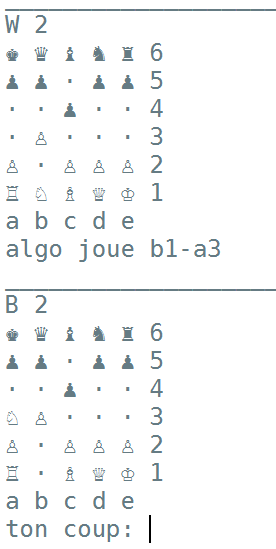

**IV - Comparaison statistique des algorithmes**

Maintenant que nous avons implémenté différents algorithmes, se pose la question de déterminer lequel est le plus efficace en terme de réussite, puisqu'ils tournent chacun pendant la même durée à chaque coup. Nous avons donc construit une fonction permettant de faire jouer deux algorithmes munis de leur fonction d'évaluation respective l'un contre l'autre.

In [ ]:
def coup_algo (position, evaluate, algo=None):
  if algo == 'minimax':
    coup=joue_minimax(position, 3, 3000, evaluate)
  elif algo == 'alpha_beta':
    coup = joue_alpha_beta(position, 5, 3000, evaluate)
  else:
   coup = coups_ord(position, evaluate)[0]
  joue_coup(position, coup)

def algo_vs_algo(evaluate_n,evaluate_b,algo_n=None,algo_b=None): 
    a=Position()
    while vainqueur(a) == '?':
        if a.coup == 'W':
            coup_algo(a,evaluate_b,algo_b)
        else:
            coup_algo(a,evaluate_n,algo_n)
    return vainqueur(a)


def apply_algo_vs_algo(evaluate_b,evaluate_n,algo_b=None,algo_n=None):
    result=algo_vs_algo(evaluate_b,evaluate_n,algo_b,algo_n)
    if result=='=':
      print('Match nul')
    elif result=='W':
      print('Victoire des Blancs')
    elif result=='B':
      print('Victoire des Noirs')


Puis la fonction définie ci-dessous nous permet de comparer à l'échelle de notre choix deux couples de fonctions d'évaluation et d'algorithmes qui s'affrontent au cours d'un match au cours duquel ils ont chacun autant de fois les noirs que les blancs.

In [ ]:
def maj_score(score,result):
  if result=='W':
    score[0] +=1
  elif result=='=':
    score[1] +=1
  elif result=='B':
    score[2] +=1

def stats(k, evaluate_x,evaluate_y,algo_x=None,algo_y=None):
    l1 = [0,0,0]
    l2 = [0,0,0]
    for i in range(k):
        result=[algo_vs_algo(evaluate_x,evaluate_y,algo_x,algo_y),algo_vs_algo(evaluate_y,evaluate_x,algo_y,algo_x)]
        maj_score(l1, result[0])
        maj_score(l2, result[1])
    print('1e algo en blanc : ', 'Premier algorithme = ',l1[0],'Nuls = ',l1[1], 'Deuxième algorithme = ',l1[2])
    print('2e algo en blanc : ', 'Premier algorithme = ',l2[2],'Nuls = ',l2[1], 'Deuxième algorithme = ',l2[0])

Lors des premières simulations, nous avons fait face à plusieurs obstacles.

Tout d'abord, nous avions gardé des valeurs de profondeur et de "duration" acceptables lorsque l'algorithme est confronté à un utilisateur, qui n'a au maximum que quelques secondes à attendre. Mais lorsque nous avons fait jouer les algorithmes minimax entre eux (avec evaluate_1), la partie a duré près de 2mn ; pour les algorithmes alpha-beta, c'était aux alentours de 5mn. Ainsi, faire des statistiques de grande ampleur aurait pris trop de temps. Nous avons donc réduit la profondeur de l'arbre des coups à explorer. Vu la structure de ces arbres dans le cas des jeux d'échecs, réduire la profondeur de 1 peut théoriquement diviser le temps de parcours par bien plus que 2 (on peut parfois avoir plus de 10 coups possibles dans une position donnée).

Ce problème temporel mis de côté, concentrons-nous sur les résultats des simulations. Ici, minimax est utilisé avec une profondeur de 3, et alpha-beta avec une profondeur de 5.


In [ ]:
stats(50,evaluate_1,evaluate_2,'minimax','minimax')

1e algo en blanc :  Premier algorithme =  25 Nuls =  12 Deuxième algorithme =  13
2e algo en blanc :  Premier algorithme =  20 Nuls =  12 Deuxième algorithme =  18


In [ ]:
stats(50,evaluate_1,evaluate_2,'alpha_beta','alpha_beta')

1e algo en blanc :  Premier algorithme =  42 Nuls =  7 Deuxième algorithme =  1
2e algo en blanc :  Premier algorithme =  44 Nuls =  4 Deuxième algorithme =  2


In [ ]:
stats(50,evaluate_1,evaluate_1,'alpha_beta','minimax')

1e algo en blanc :  Premier algorithme =  25 Nuls =  17 Deuxième algorithme =  8
2e algo en blanc :  Premier algorithme =  26 Nuls =  14 Deuxième algorithme =  10


In [ ]:
stats(50,evaluate_2,evaluate_2,'alpha_beta','minimax')

1e algo en blanc :  Premier algorithme =  6 Nuls =  15 Deuxième algorithme =  29
2e algo en blanc :  Premier algorithme =  8 Nuls =  19 Deuxième algorithme =  23


In [ ]:
stats(50,evaluate_2,evaluate_1,'alpha_beta','minimax')

1e algo en blanc :  Premier algorithme =  3 Nuls =  14 Deuxième algorithme =  33
2e algo en blanc :  Premier algorithme =  3 Nuls =  15 Deuxième algorithme =  32


Il s'agit tout d'abord de noter que même en réduisant la profondeur, l'échantillon ainsi obtenu pour chaque match reste relativement réduit.

Cependant, on peut d'emblée remarquer que la fonction d'évaluation 2, pourtant plus élaborée et donc en théorie plus précise quant à la détermination du meilleur coup, est écrasée par la fonction d'évaluation 1 quand les deux sont associées à alpha-beta ; même cas de figure avec minimax, avec des résultats certes plus serrés.

Par ailleurs, alpha-beta, à qui l'on associe une profondeur supérieure et qui est censé être plus rapide grâce au pruning, se fait battre à plates coutures par minimax lorsque l'on associe la fonction d'évaluation 2 aux deux, alors qu'il l'emporte assez largement avec la fonction d'évaluation 1.Ceci suggèrerait que la fonction d'évaluation 2 devient moins précise quand la profondeur augmente. Mais il est également concevable que la profondeur ne soit au contraire pas assez importante pour révéler les qualités de la fonction d'évaluation 2.

Une dernière hypothèse intéressante serait que cette fonction soit fondée sur des principes théoriques valables aux échecs classiques, mais pas en 5x6. L'intérêt de cette variante pour les joueurs évoqué en introduction se reflèterait donc ici. 



Nous ne sommes pas allés plus loin dans l'étude statistique de ces algorithmes car l'essentiel était qu'ils soient capables de jouer convenablement contre un utilisateur, ce qui est le cas. (Naël a réussi à battre minimax à profondeur 4 avec les blancs et forcer le nul avec les noirs, mais pas de résultat contre alpha-beta). Nous avons cependant pensé à quelques pistes qu'il serait éventuellement intéressant d'explorer. Tout d'abord, il serait intéressant étudier l'évolution des écarts de résultats avec la profondeur (en gardant la même profondeur pour les algorithmes qui s'affrontent) ; le problème est que pour une profondeur de 1 ou 2, l'algorithme n'est pas très intelligent, et qu'à une profondeur de 5 ou plus, cela prend beaucoup de temps à tourner.

Nous pourrions aussi tenter de voir à partir de quelle profondeur evaluate_2 "rattrape" evaluate_1 (dont la profondeur resterait fixe lors du procédé).

Dans tout ces cas de figure, il faudrait bien évidemment augmenter la variable "duration" (et la garder égale entre les algorithmes qui s'affrontent) pour ne pas limiter le parcours des coups possibles par l'algorithme.